# Airline Ticket Pricing Analysis ✈️

**Objective:**  
Explore airline ticket price patterns, understand factors driving price fluctuations, and build a predictive model.  
**Dataset:** 300,000+ flight records, with columns: airline, source_city, destination_city, departure_time, arrival_time, class, duration, days_left, price.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

# Load data
df = pd.read_csv("airline_cleaned.csv") # <-- Replace if filename differs
print("Initial shape:", df.shape)
display(df.head())

# Remove duplicates
df = df.drop_duplicates()

# Uniform string columns
for col in ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time', 'class', 'stops']:
    df[col] = df[col].str.strip().str.title()

# Create route column
df["route"] = df["source_city"] + " → " + df["destination_city"]

# Convert types
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
df['price']    = pd.to_numeric(df['price'], errors='coerce')
df['days_left']= pd.to_numeric(df['days_left'], errors='coerce')

# Drop rows with NA after conversion
df = df.dropna()
print("After cleaning:", df.shape)


Initial shape: (300045, 12)


,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953.0
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953.0
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956.0
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955.0
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955.0


After cleaning: (300045, 13)


# Exploratory Data Analysis (EDA)

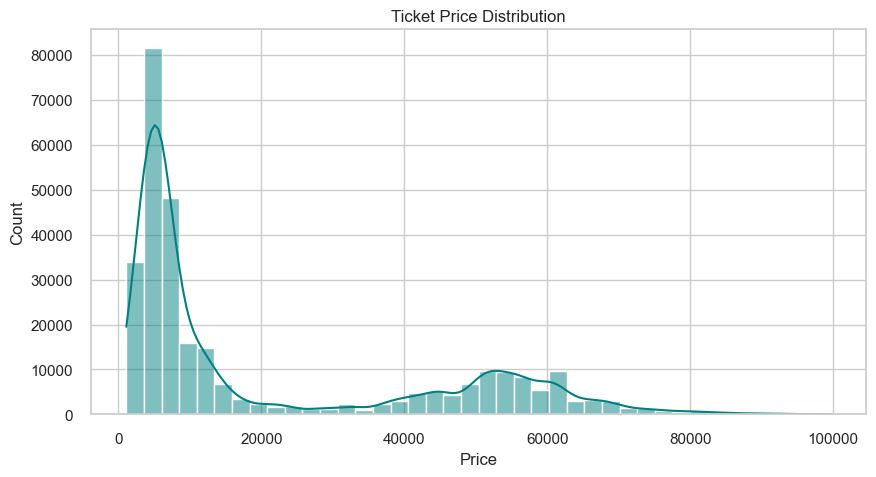

In [2]:
plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=40, kde=True, color='teal')
plt.title("Ticket Price Distribution")
plt.xlabel("Price")
plt.show()


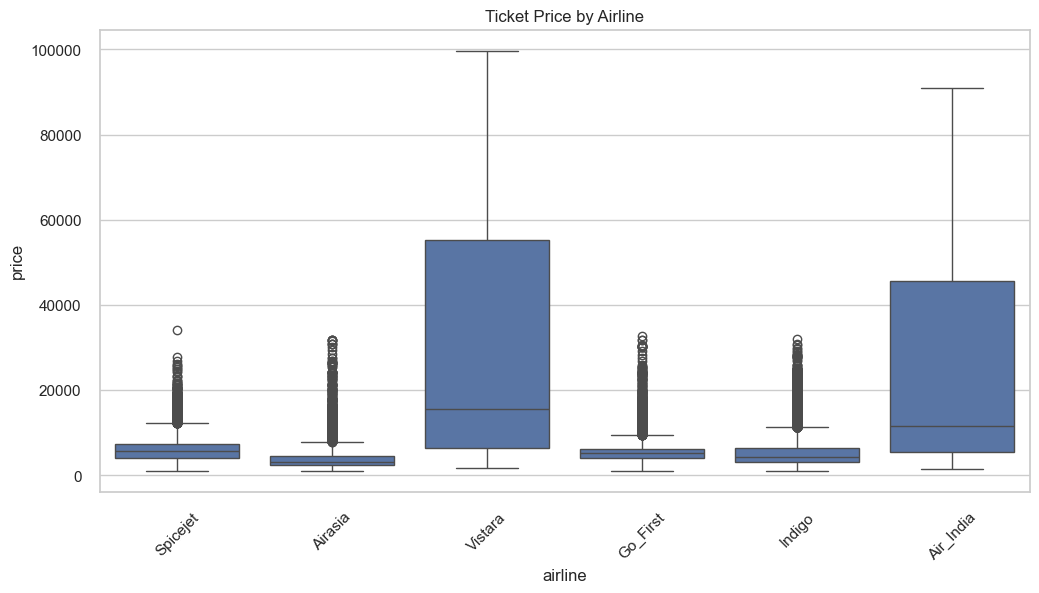

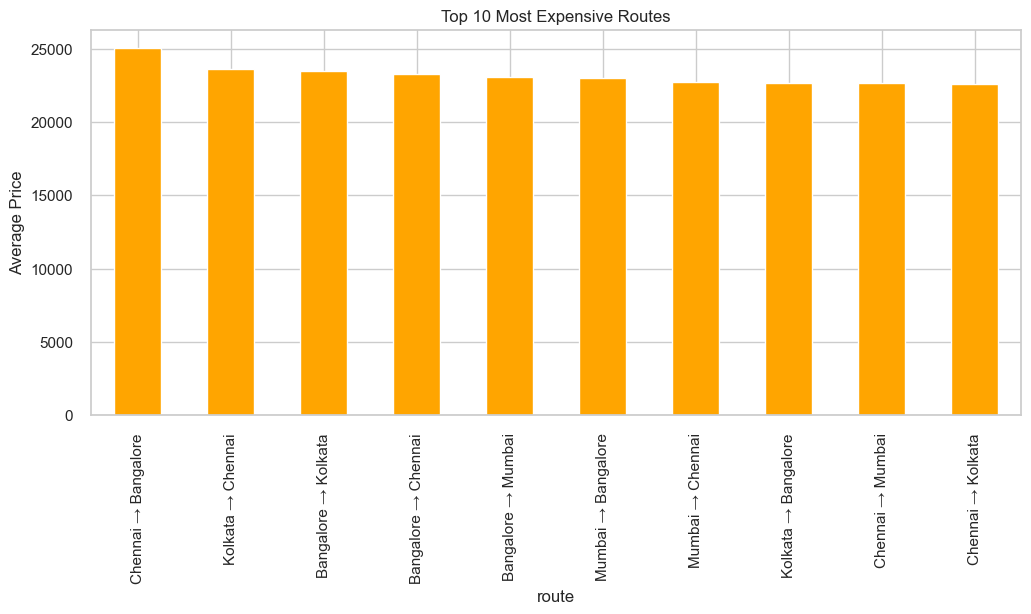

In [3]:
plt.figure(figsize=(12,6))
sns.boxplot(x='airline', y='price', data=df)
plt.xticks(rotation=45)
plt.title("Ticket Price by Airline")
plt.show()

# Top 10 Most Expensive Routes
df.groupby("route")["price"].mean().sort_values(ascending=False).head(10).plot.bar(figsize=(12,5), color='orange')
plt.ylabel("Average Price")
plt.title("Top 10 Most Expensive Routes")
plt.show()


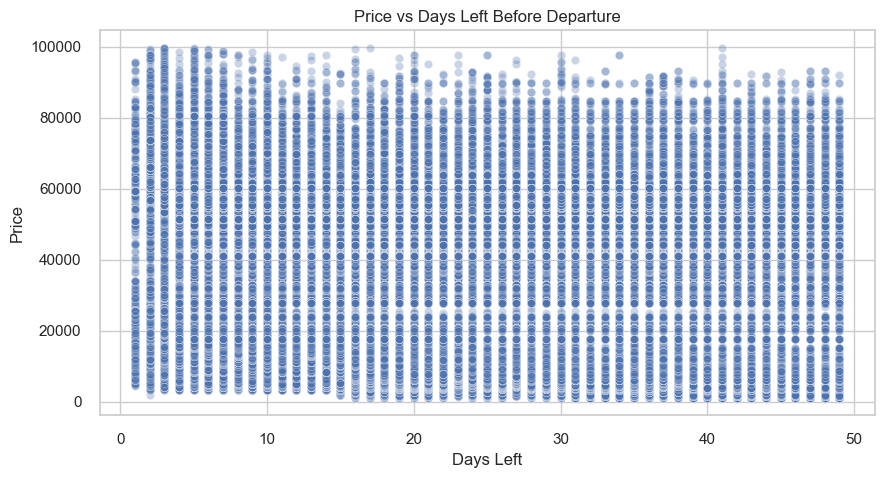

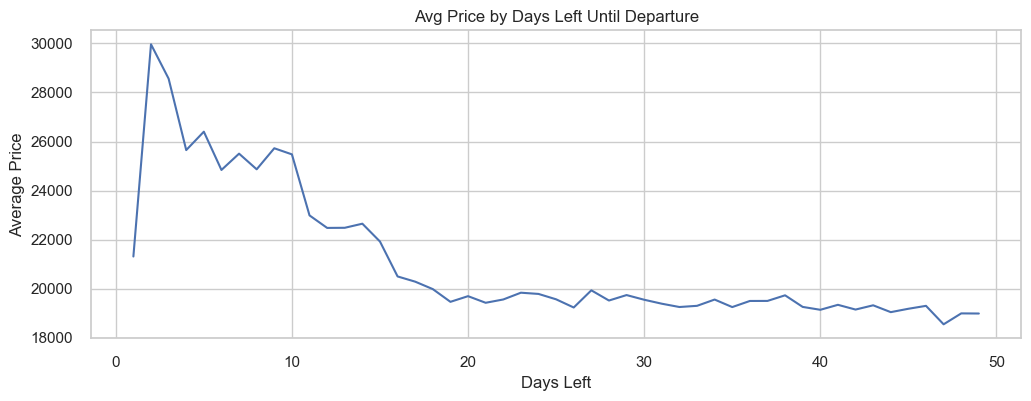

In [4]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='days_left', y='price', data=df, alpha=0.3)
plt.title("Price vs Days Left Before Departure")
plt.xlabel("Days Left")
plt.ylabel("Price")
plt.show()

# Average price trend by days_left
mean_by_day = df.groupby('days_left')['price'].mean()
plt.figure(figsize=(12,4))
mean_by_day.plot()
plt.title("Avg Price by Days Left Until Departure")
plt.xlabel("Days Left")
plt.ylabel("Average Price")
plt.show()


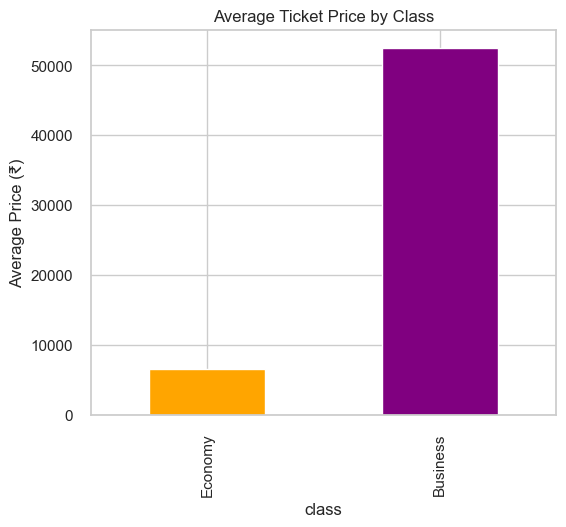

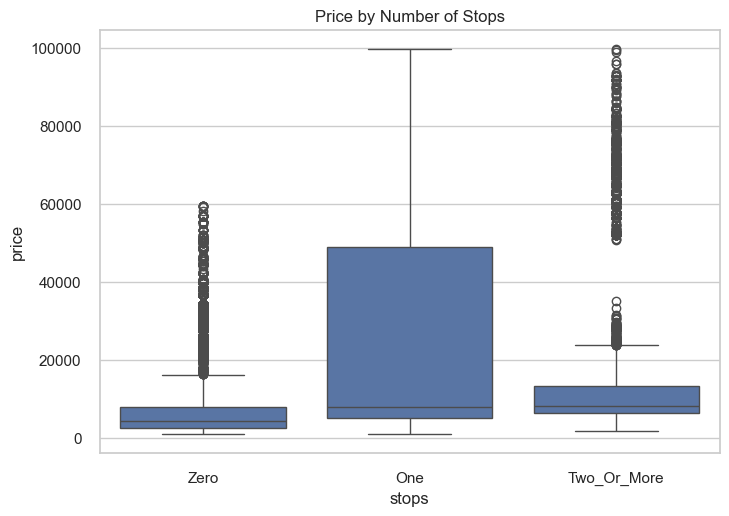

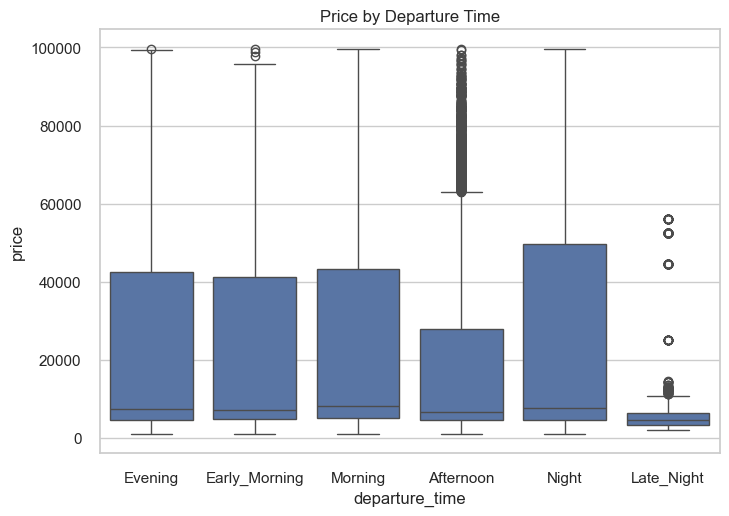

In [5]:
# Class
class_price = df.groupby('class')['price'].mean().sort_values()
plt.figure(figsize=(6,5))
class_price.plot(kind='bar', color=['orange','purple'])
plt.title("Average Ticket Price by Class")
plt.ylabel("Average Price (₹)")
plt.show()

# Stops
sns.boxplot(x='stops', y='price', data=df)
plt.title("Price by Number of Stops")
plt.show()

# Departure time
sns.boxplot(x='departure_time', y='price', data=df)
plt.title("Price by Departure Time")
plt.show()


In [ ]:
import scipy.stats as stats
anova = stats.f_oneway(*(df[df['airline']==al]['price'] for al in df['airline'].unique()))
print("ANOVA p-value (price difference between airlines):", anova.pvalue)


In [ ]:
eco = df[df['class']=="Economy"]["price"]
bus = df[df['class']=="Business"]["price"]
ttest = stats.ttest_ind(eco, bus, equal_var=False)
print("T-test p-value (Economy vs Business):", ttest.pvalue)


In [ ]:
X = df[['airline', 'class', 'route', 'days_left', 'duration', 'stops', 'departure_time', 'arrival_time']]
y = df['price']

# Encode categorical
X_enc = pd.get_dummies(X, drop_first=True)
print("Encoded shape:", X_enc.shape)


#  Model, Train, Evaluate

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("MAE on test set:", mean_absolute_error(y_test, y_pred))
print("R² on test set:", r2_score(y_test, y_pred))

NameError: name 'X_enc' is not defined

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X_enc.columns).sort_values(ascending=False)
importances.head(12).plot(kind='barh')
plt.title("Top 12 Features Influencing Ticket Price")
plt.show()

### Key Insights:
- **Booking Window:** Prices rise steeply in the last 5 days before departure; booking 15+ days ahead yields substantial savings.
- **High-Demand/High-Priced Routes:** Mumbai–Bangalore, Mumbai–Kolkata are consistently the most expensive.
- **Class Gap:** Business class tickets command a premium nearly 3x that of economy.
- **Non-stop Premium:** Zero-stop flights average about 15–20% higher fares.
- **Airline/Time Influence:** Certain airlines and early-morning departures can yield lower prices, depending on route.

### Recommendations:
- **For Airlines:** Dynamic pricing for last-minute tickets to fill empty seats; promo fares on under-filled routes.
- **For Agencies/Apps:** Encourage bookings 2–3 weeks in advance for cost-savings; highlight best-value carriers per route.
- **For Customers:** Avoid last-minute bookings for premium routes; consider early/midweek flights and economy class for best rates.

### Next Steps:
- Incorporate season/holiday surges for improved modeling.
- Build an interactive dashboard for self-service fare prediction.
